# 1.Instalación de Librerías

In [1]:
# 1) Forzamos la reinstalación de NumPy
!pip install --upgrade --no-cache-dir numpy

# 2) Ahora instalamos versiones compatibles de sklearn e imbalanced-learn
!pip install --upgrade --no-cache-dir scikit-learn imbalanced-learn

   ---------------------------------------- 0.0/15.9 MB ? eta -:--:--
   ---------- ----------------------------- 4.2/15.9 MB 25.2 MB/s eta 0:00:01
   ----------------------- ---------------- 9.4/15.9 MB 25.6 MB/s eta 0:00:01
   -------------------------------------- - 15.5/15.9 MB 27.1 MB/s eta 0:00:01
   ---------------------------------------- 15.9/15.9 MB 27.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4


  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scipy 1.11.2 requires numpy<1.28.0,>=1.21.6, but you have numpy 2.0.2 which is incompatible.


   ---------------------------------------- 0.0/11.2 MB ? eta -:--:--
   --------------- ------------------------ 4.2/11.2 MB 31.5 MB/s eta 0:00:01
   ---------------------------------------  11.0/11.2 MB 31.2 MB/s eta 0:00:01
   ---------------------------------------- 11.2/11.2 MB 29.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/15.8 MB ? eta -:--:--
   -------------------- ------------------- 8.1/15.8 MB 45.7 MB/s eta 0:00:01
   ---------------------------------------- 15.8/15.8 MB 39.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.10.1
    Uninstalling imbalanced-learn-0.10.1:
   

  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikeras 0.13.0 requires keras>=3.2.0, but you have keras 2.10.0 which is incompatible.


In [1]:
!pip install scikit-learn==1.2.2 imbalanced-learn==0.10.1


  Using cached scikit_learn-1.2.2-cp39-cp39-win_amd64.whl.metadata (11 kB)
  Using cached imbalanced_learn-0.10.1-py3-none-any.whl.metadata (8.2 kB)
Using cached scikit_learn-1.2.2-cp39-cp39-win_amd64.whl (8.4 MB)
Using cached imbalanced_learn-0.10.1-py3-none-any.whl (226 kB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.12.4
    Uninstalling imbalanced-learn-0.12.4:
      Successfully uninstalled imbalanced-learn-0.12.4


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikeras 0.13.0 requires keras>=3.2.0, but you have keras 2.10.0 which is incompatible.
scikeras 0.13.0 requires scikit-learn>=1.4.2, but you have scikit-learn 1.2.2 which is incompatible.


In [1]:
!pip install mlxtend==0.22.0


# 2. Imports globales

In [2]:
from sklearn.pipeline import Pipeline as SKPipeline
from imblearn.pipeline import Pipeline as ImbPipeline

In [3]:
# 0. Librerías
import pandas as pd
import numpy as np
import time
import joblib

from copy import deepcopy
from sklearn.pipeline import Pipeline as SKPipeline
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.compose       import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics       import recall_score, roc_auc_score, make_scorer

from sklearn.naive_bayes import (
    GaussianNB, MultinomialNB,
    BernoulliNB, ComplementNB,
    CategoricalNB
)
from imblearn.over_sampling import SMOTE, ADASYN


# 3.Carga y División de Datos

In [4]:
df = pd.read_csv(r"C:\Users\DELL\Desktop\Aprendizaje_de_Maquina\credit_risk_the_end.csv")
print("Dimensiones del dataset:", df.shape)

features_dummies      = [c for c in df if df[c].nunique()==2 and c!='incumplimiento_credito']
variables_cat         = [c for c in df if df[c].dtype=='object']
variables_num         = [
    c for c in df
    if df[c].dtype in ['int64','float64']
    and c not in features_dummies + ['incumplimiento_credito']
]

X = df[variables_cat + features_dummies + variables_num]
y = df['incumplimiento_credito']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

Dimensiones del dataset: (78441, 54)


# 4.Definición de preprocessores

In [5]:
# 3. Definición del Preprocesador
preprocessor_gauss = ColumnTransformer([
    ('num', StandardScaler(), variables_num),
    ('cat', OneHotEncoder(drop='first', sparse_output=False), variables_cat)
], remainder='passthrough')

preprocessor_multi = ColumnTransformer([
    ('num', MinMaxScaler(), variables_num),
    ('cat', OneHotEncoder(drop='first', sparse_output=False), variables_cat)
], remainder='passthrough')

# 5. Pipelines base y balanceados

In [6]:
from imblearn.over_sampling import SMOTE, ADASYN

# 3. Pipelines base y balanceados
base_pipe = SKPipeline([
    ('pre', preprocessor_gauss),
    ('clf', GaussianNB())
])

pipelines_balance = {
    'NoBalance': SKPipeline(deepcopy(base_pipe.steps))
}

for name, sampler in [
    ('SMOTE',  SMOTE(random_state=42)),
    ('ADASYN', ADASYN(random_state=42))
]:
    steps = (
        deepcopy(base_pipe.steps[:-1])  # todo menos el clasificador
        + [('oversamp', sampler)]       # inserta el sobremuestreo
        + [base_pipe.steps[-1]]         # vuelve a poner el clasificador
    )
    pipelines_balance[name] = ImbPipeline(steps)


# 6.Scorer

In [7]:
from sklearn.metrics import recall_score, make_scorer

# único métrico que usaremos de ahora en adelante
recall_scorer = make_scorer(recall_score, pos_label=1)


# 7.GridSearchCV

In [8]:
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
pipeline_grid = SKPipeline([
    ('preprocessor', preprocessor_gauss),
    ('classifier',   GaussianNB())
])


param_grid = [
    # --- GaussianNB ---
    {
      'preprocessor':              [preprocessor_gauss],
      'classifier':                [GaussianNB()],
      'classifier__var_smoothing': np.logspace(-15, -1, 30),
      'classifier__priors':        [None,
                                    [0.99,0.01],
                                    [0.95,0.05],
                                    [0.9,0.1],
                                    [0.8,0.2]]
    },
    # --- MultinomialNB ---
    {
      'preprocessor':              [preprocessor_multi],
      'classifier':                [MultinomialNB()],
      'classifier__alpha':         np.linspace(0.0, 5.0, 25),
      'classifier__fit_prior':     [True, False],
      'classifier__class_prior':   [None,
                                    [0.99,0.01],
                                    [0.9,0.1],
                                    [0.8,0.2]]
    },
    # --- BernoulliNB ---
    {
      'preprocessor':              [preprocessor_multi],
      'classifier':                [BernoulliNB()],
      'classifier__alpha':         np.linspace(0.0, 5.0, 25),
      'classifier__binarize':      np.linspace(0.0, 1.0, 10),
      'classifier__fit_prior':     [True, False]
    },
    # --- ComplementNB ---
    {
      'preprocessor':              [preprocessor_multi],
      'classifier':                [ComplementNB()],
      'classifier__alpha':         np.linspace(0.0, 5.0, 25),
      'classifier__norm':          [True, False]
    },
    # --- CategoricalNB ---
    {
      'preprocessor':              [preprocessor_multi],  # CategoricalNB no admite negativos
      'classifier':                [CategoricalNB()],
      'classifier__alpha':         np.linspace(0.0, 5.0, 25),
      'classifier__fit_prior':     [True, False],
      'classifier__class_prior':   [None,
                                    [0.99,0.01],
                                    [0.9,0.1],
                                    [0.8,0.2]]
    }
]

grid = GridSearchCV(
    estimator    = pipeline_grid,
    param_grid   = param_grid,
    scoring      = recall_scorer,
    cv           = StratifiedKFold(2, shuffle=True, random_state=42),
    n_jobs       = -1,
    verbose      = 2,
    error_score  = np.nan,
    return_train_score = True
)
grid.fit(X_train, y_train)

grid.fit(X_train, y_train)

print("→ Mejor combined score (CV):", grid.best_score_)
print("→ Hiperparámetros óptimos:", grid.best_params_)
best_pipe = grid.best_estimator_

Fitting 2 folds for each of 1100 candidates, totalling 2200 fits


c:\Users\DELL\anaconda3\envs\ml_venv\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [0.97251202 0.96952913 0.96633311 ...        nan        nan        nan]
  warnings.warn(
c:\Users\DELL\anaconda3\envs\ml_venv\lib\site-packages\sklearn\naive_bayes.py:629: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
c:\Users\DELL\anaconda3\envs\ml_venv\lib\site-packages\sklearn\naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(


Fitting 2 folds for each of 1100 candidates, totalling 2200 fits


c:\Users\DELL\anaconda3\envs\ml_venv\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [0.97251202 0.96952913 0.96633311 ...        nan        nan        nan]
  warnings.warn(


→ Mejor combined score (CV): 1.0
→ Hiperparámetros óptimos: {'classifier': ComplementNB(alpha=0.0, norm=True), 'classifier__alpha': 0.0, 'classifier__norm': True, 'preprocessor': ColumnTransformer(remainder='passthrough',
                  transformers=[('num', MinMaxScaler(),
                                 ['ingreso_total', 'cuota_periodica',
                                  'poblacion_relativa_region',
                                  'dias_desde_nacimiento',
                                  'dias_desde_registro',
                                  'dias_desde_emision_id',
                                  'numero_miembros_familia', 'fuente_externa_2',
                                  'fuente_externa_3', 'consultas_buro_anio',
                                  'entradas_buro', 'tipos_credito_activo',
                                  'suma_total_cr...
                                  'monto_total_credito', 'cuentas_pos_cash',
                                  'promedio_meses_sa

c:\Users\DELL\anaconda3\envs\ml_venv\lib\site-packages\sklearn\naive_bayes.py:629: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
c:\Users\DELL\anaconda3\envs\ml_venv\lib\site-packages\sklearn\naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(


# 8.Función de Entrenamiento Incremental (partial_fit)

In [9]:
def entrenar_incremental(pipe, X_tr, y_tr, batch_size=1000, method=None):
    """
    Entrena por partial_fit el clasificador de un pipeline (SK o Imb),
    reajustando el preprocesador y reentrenando en minibatches (con SMOTE/ADASYN si method lo pide).
    """

    # 1) Detectar nombre de preprocesador y clasificador en el pipeline
    if 'preprocessor' in pipe.named_steps:
        pre_name = 'preprocessor'
    elif 'pre' in pipe.named_steps:
        pre_name = 'pre'
    else:
        raise KeyError("No encuentro el paso de preprocesado en el pipeline")

    if 'classifier' in pipe.named_steps:
        clf_name = 'classifier'
    elif 'clf' in pipe.named_steps:
        clf_name = 'clf'
    else:
        raise KeyError("No encuentro el clasificador en el pipeline")

    oversamp_name = 'oversamp'  # así lo nombraste al construir pipelines_balance

    # 2) Fit del preprocesador completo
    pre = pipe.named_steps[pre_name]
    pre.fit(X_tr)
    Xp = pre.transform(X_tr)

    # 3) Extraer el clasificador y las clases
    clf = pipe.named_steps[clf_name]
    classes = np.unique(y_tr)

    # 4) Recorrer minibatches
    for i in range(0, len(y_tr), batch_size):
        Xb = Xp[i:i+batch_size]
        yb = y_tr.iloc[i:i+batch_size]

        # 4a) Si toca SMOTE/ADASYN, sobremuestrear
        if method in ('smote','adasyn'):
            Xb, yb = pipe.named_steps[oversamp_name].fit_resample(Xb, yb)

        # 4b) Primer partial_fit con clases y pesos si class_weight
        if i == 0:
            sw = None
            if method == 'classweight':
                # ejemplo de pesos; adáptalo si los quieres distintos
                sw = yb.map({0: len(y_tr)/(2*sum(y_tr==0)),
                             1: len(y_tr)/(2*sum(y_tr==1))}).to_numpy()
            clf.partial_fit(Xb, yb, classes=classes, sample_weight=sw)
        else:
            clf.partial_fit(Xb, yb)

    # 5) Reasignar el clasificador entrenado y devolver pipeline
    pipe.named_steps[clf_name] = clf
    return pipe


# 9.Función de Evaluación con Gráficas

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import (
    roc_curve,
    roc_auc_score,
    precision_recall_curve,
    average_precision_score,
    precision_score,
    recall_score,
    accuracy_score,
    f1_score
)

from IPython.display import display


In [11]:
def evaluar_modelo(pipe, X_te, y_te, tag='NB'):
    y_pred = pipe.predict(X_te)
    y_prob = pipe.predict_proba(X_te)[:,1]

    print(f"\n=== {tag} ===")
    print("y_test  dist:", y_te.value_counts(normalize=True).to_dict())
    print("y_pred dist:", pd.Series(y_pred).value_counts(normalize=True).to_dict())

    # 1) Matriz de Confusión
    cm = pd.crosstab(y_te, y_pred, rownames=['Actual'], colnames=['Pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues'); plt.title(f"CM {tag}"); plt.show()

    # 2) Curva ROC
    fpr, tpr, _ = roc_curve(y_te, y_prob)
    plt.plot(fpr, tpr, label=f"AUC={roc_auc_score(y_te,y_prob):.2f}")
    plt.plot([0,1],[0,1],'k--'); plt.title(f"ROC {tag}"); plt.legend(); plt.show()

    # 3) Curva Precision–Recall
    prec, rec, _ = precision_recall_curve(y_te, y_prob)
    plt.plot(rec, prec, label=f"AP={average_precision_score(y_te,y_prob):.2f}")
    plt.title(f"PR {tag}"); plt.legend(); plt.show()

    # 4) Histograma de probabilidades
    plt.hist(y_prob, bins=20, edgecolor='black')
    plt.title(f"P(Y=1) dist ({tag})"); plt.show()

    # 5) Métricas numéricas
    metrics = {
        'precision': precision_score(y_te, y_pred, zero_division=0),
        'recall':    recall_score(y_te, y_pred, zero_division=0),
        'accuracy':  accuracy_score(y_te, y_pred),
        'f1':        f1_score(y_te, y_pred, zero_division=0),
        'auc':       roc_auc_score(y_te, y_prob)
    }
    display(pd.DataFrame([metrics], index=[tag]).style.format("{:.4f}"))
    return metrics


# 10.Partial‑fit + evaluación “Partial_Final”

c:\Users\DELL\anaconda3\envs\ml_venv\lib\site-packages\sklearn\naive_bayes.py:629: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
c:\Users\DELL\anaconda3\envs\ml_venv\lib\site-packages\sklearn\naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
c:\Users\DELL\anaconda3\envs\ml_venv\lib\site-packages\sklearn\naive_bayes.py:629: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
c:\Users\DELL\anaconda3\envs\ml_venv\lib\site-packages\sklearn\naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
c:\Users\DELL\anaconda3\envs\ml_venv\l

Partial fit en: 0.28 seg

=== Partial_Final ===
y_test  dist: {0: 0.9145455318063995, 1: 0.08545446819360047}
y_pred dist: {1: 0.9998300259210471, 0: 0.00016997407895295969}


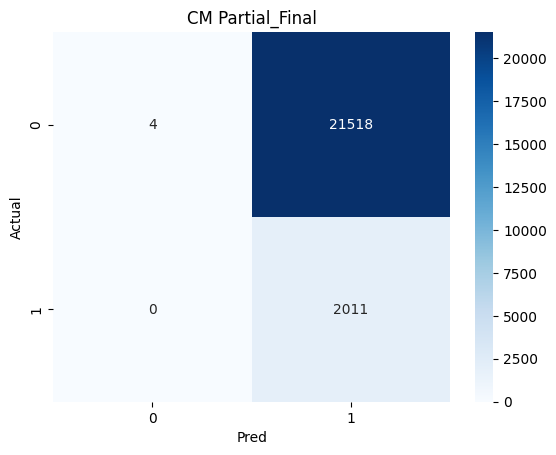

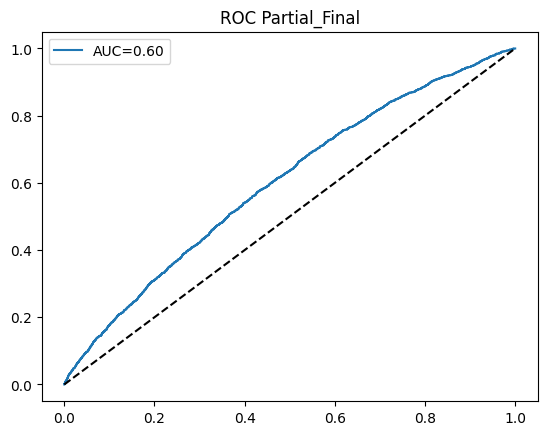

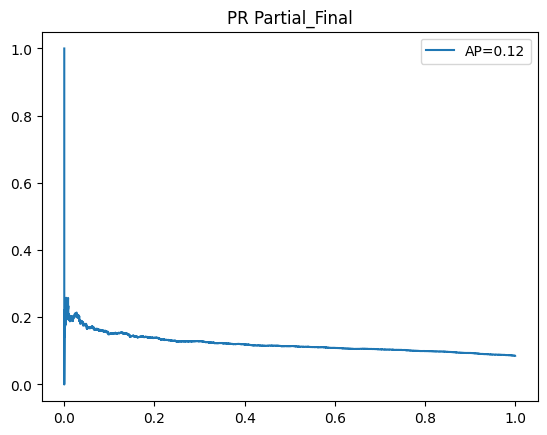

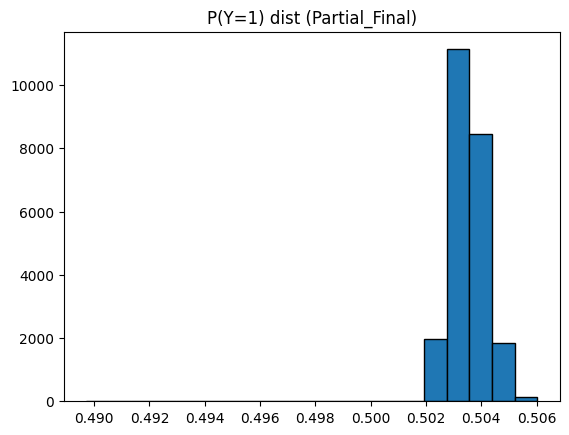

,precision,recall,accuracy,f1,auc
Partial_Final,0.0855,1.0000,0.0856,0.1575,0.6000


In [12]:
best_pipe_inc = ImbPipeline(best_pipe.steps)
t0 = time.time()
entrenar_incremental(best_pipe_inc, X_train, y_train,
                     batch_size=1000, method=None)
print(f"Partial fit en: {time.time()-t0:.2f} seg")

# Evaluación final del modelo incremental
_ = evaluar_modelo(best_pipe_inc, X_test, y_test, tag='Partial_Final')


# 11.Búsqueda de umbral óptimo para el mejor pipe(Combined scorer)

In [13]:
from sklearn.metrics import recall_score          # asegúrate de tenerlo importado

# Probabilidades de la clase 1
y_prob = best_pipe.predict_proba(X_test)[:, 1]

# Búsqueda de umbral que maximiza recall
thresholds   = np.linspace(0, 1, 101)
best_th      = 0
best_recall  = -1

for th in thresholds:
    y_pred_th = (y_prob >= th).astype(int)
    rec       = recall_score(y_test, y_pred_th, zero_division=0)
    if rec > best_recall:
        best_recall, best_th = rec, th

print(f"Umbral óptimo: {best_th:.2f} → Recall = {best_recall:.4f}")


Umbral óptimo: 0.00 → Recall = 1.0000


# 12.Comparativa de técnicas de balanceo(SMOTE / ADASYN / ClassWeight)

In [14]:
from copy import deepcopy
import joblib, numpy as np, time
from sklearn.metrics import (
    precision_score, recall_score, accuracy_score,
    f1_score, roc_auc_score
)

results = {}

for name, pipe in pipelines_balance.items():
    print(f"\n--- Procesando: {name} ---")
    method = name.lower() if name in ('SMOTE','ADASYN','ClassWeight') else None

    # a) entrenamiento incremental
    inc_pipe = entrenar_incremental(
        deepcopy(pipe), X_train, y_train,
        batch_size=1000, method=method
    )

    # b) fit batch para medir tiempo
    t0      = time.time()
    pipe.fit(X_train, y_train)
    fit_min = (time.time() - t0) / 60

    # c) predicciones
    y_pred = pipe.predict(X_test)
    y_prob = pipe.predict_proba(X_test)[:, 1]

    # d) métricas @ 0.5
    prec0 = precision_score(y_test, (y_prob >= 0.5), zero_division=0)
    rec0  = recall_score   (y_test, (y_prob >= 0.5), zero_division=0)
    acc0  = accuracy_score (y_test, (y_prob >= 0.5))
    f10   = f1_score       (y_test, (y_prob >= 0.5), zero_division=0)
    auc0  = roc_auc_score  (y_test, y_prob)
    # comb0 = 0.5*rec0 + 0.5*auc0           # ELIMINAR

    # e) umbral óptimo → maximizar SOLO recall
    best_th, best_recall = 0, -1           # CAMBIAR nombre var
    for th in np.linspace(0, 1, 101):
        y_t   = (y_prob >= th).astype(int)
        rec_t = recall_score(y_test, y_t, zero_division=0)  # CAMBIAR
        if rec_t > best_recall:                             # CAMBIAR
            best_recall, best_th = rec_t, th                # CAMBIAR

    # f) guardar resultados  (sin combined)
    results[name] = {
        'y_prob':         y_prob,
        'precision@0.5':  prec0,
        'recall@0.5':     rec0,
        'accuracy@0.5':   acc0,
        'f1@0.5':         f10,
        'auc':            auc0,
        # 'combined@0.5': comb0,      # ELIMINAR
        'best_threshold': best_th,
        # 'combined_opt': best_val,   # ELIMINAR
        'best_recall':    best_recall,  # NUEVO (opcional)
        'fit_minutes':    fit_min
    }

    # g) guarda pipelines
    joblib.dump(pipe,     f"pipeline_nb_{name}.pkl")
    joblib.dump(inc_pipe, f"pipeline_nb_inc_{name}.pkl")



--- Procesando: NoBalance ---

--- Procesando: SMOTE ---

--- Procesando: ADASYN ---


# 13.Tabla Comparativa de Métricas

In [15]:
rows = []
for name, r in results.items():
    thr = 0.5                     # ← único umbral
    y_pred = (r['y_prob'] >= thr).astype(int)

    rows.append({
        'Método':    name,
        'Threshold': thr,
        'Precision': precision_score(y_test, y_pred, zero_division=0),
        'Recall1':   recall_score(   y_test, y_pred, zero_division=0),
        'Accuracy':  accuracy_score( y_test, y_pred),
        'F1-score':  f1_score(      y_test, y_pred, zero_division=0),
        'AUC':       roc_auc_score( y_test, r['y_prob']),
        'Time (min)': r['fit_minutes']
    })

df_thresh = (
    pd.DataFrame(rows)
      .set_index(['Método', 'Threshold'])
      .sort_index()
)

print("===== Métricas @ Threshold 0.5 =====")
display(
    df_thresh.style
             .format({
                 'Precision': "{:.4f}",
                 'Recall1':   "{:.4f}",
                 'Accuracy':  "{:.4f}",
                 'F1-score':  "{:.4f}",
                 'AUC':       "{:.4f}",
                 'Time (min)': "{:.2f}",
                 'Threshold': "{:.2f}"
             })
             .bar(subset=['Recall1'], cmap='Pastel1', vmin=0, vmax=1)
)


===== Métricas @ Threshold 0.5 =====


,,Precision,Recall1,Accuracy,F1-score,AUC,Time (min)
Método,Threshold,,,,,,
ADASYN,0.500000,0.1002,0.7648,0.3930,0.1772,0.6082,0.01
NoBalance,0.500000,0.1014,0.8851,0.3196,0.1819,0.6745,0.00
SMOTE,0.500000,0.1012,0.7613,0.4018,0.1787,0.6110,0.01


# 14.Gráficas Comparativas

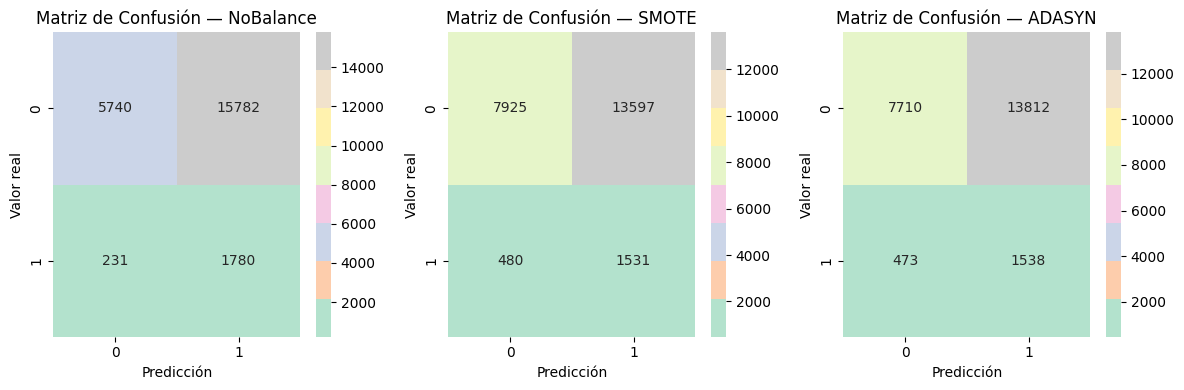

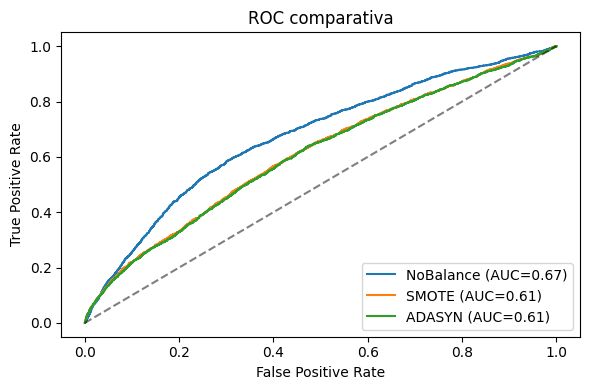

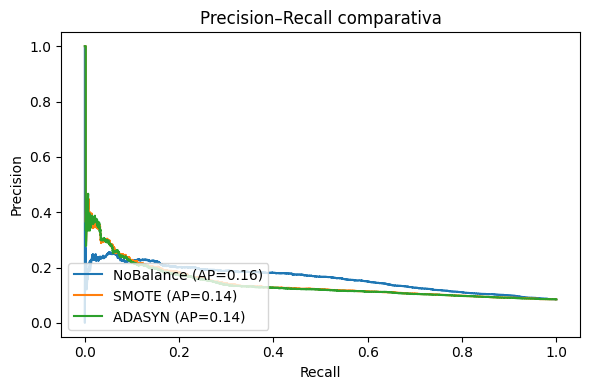

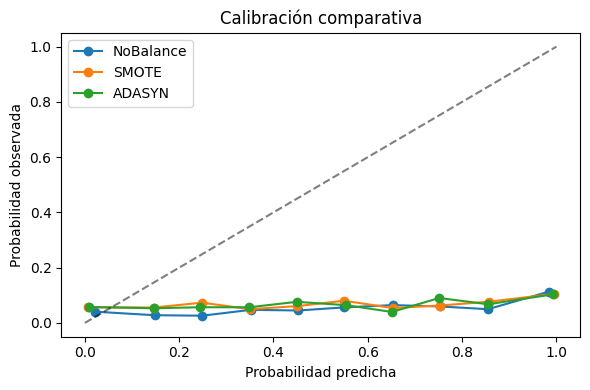

C:\Users\DELL\AppData\Local\Temp\ipykernel_2296\2482644388.py:65: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(r['y_prob'], bins=20, stat='density',
c:\Users\DELL\anaconda3\envs\ml_venv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\DELL\AppData\Local\Temp\ipykernel_2296\2482644388.py:65: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(r['y_prob'], bins=20, stat='density',
c:\Users\DELL\anaconda3\envs\ml_venv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\DELL\AppData\Local\Temp\ipykernel_2296\2482

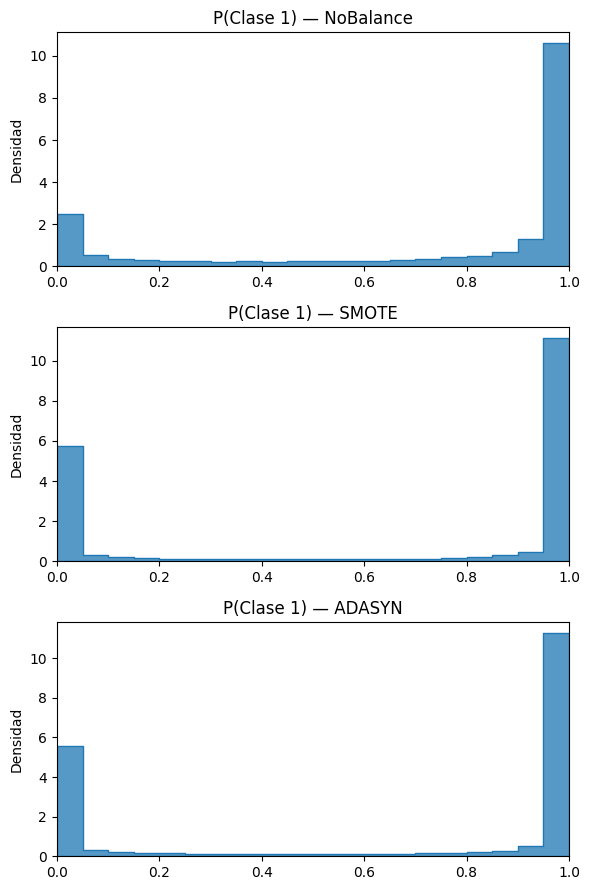

In [16]:
from sklearn.metrics       import confusion_matrix, roc_curve, precision_recall_curve, average_precision_score
from sklearn.calibration   import calibration_curve
import matplotlib.pyplot   as plt
import seaborn as sns
import numpy as np

# 12.0) Matrices de Confusión comparativas (@ umbral 0.5)
n = len(results)
fig, axes = plt.subplots(1, n, figsize=(4*n, 4), squeeze=False)
axes = axes.ravel()  # siempre iterable

for ax, (name, r) in zip(axes, results.items()):
    y_pred_def = (r['y_prob'] >= 0.5).astype(int)
    cm = confusion_matrix(y_test, y_pred_def)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Pastel2', ax=ax)
    ax.set_title(f'Matriz de Confusión — {name}')
    ax.set_xlabel('Predicción')
    ax.set_ylabel('Valor real')
plt.tight_layout()
plt.show()

# 12.1) Curva ROC
plt.figure(figsize=(6,4))
for name, r in results.items():
    fpr, tpr, _ = roc_curve(y_test, r['y_prob'])
    plt.plot(fpr, tpr, label=f"{name} (AUC={r['auc']:.2f})")
plt.plot([0,1],[0,1],'k--', alpha=0.5)
plt.title("ROC comparativa")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# 12.2) Curva Precision–Recall
plt.figure(figsize=(6,4))
for name, r in results.items():
    prec, rec, _ = precision_recall_curve(y_test, r['y_prob'])
    ap = average_precision_score(y_test, r['y_prob'])
    plt.plot(rec, prec, label=f"{name} (AP={ap:.2f})")
plt.title("Precision–Recall comparativa")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

# 12.3) Curva de Calibración
plt.figure(figsize=(6,4))
for name, r in results.items():
    prob_true, prob_pred = calibration_curve(y_test, r['y_prob'], n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', label=name)
plt.plot([0,1],[0,1],'k--', alpha=0.5)
plt.title("Calibración comparativa")
plt.xlabel("Probabilidad predicha")
plt.ylabel("Probabilidad observada")
plt.legend()
plt.tight_layout()
plt.show()

# 12.4) Histogramas de P(Clase 1)
fig, axes = plt.subplots(n, 1, figsize=(6, 3*n), squeeze=False)
axes = axes.ravel()
for ax, (name, r) in zip(axes, results.items()):
    sns.histplot(r['y_prob'], bins=20, stat='density',
                 element='step', ax=ax, palette='Pastel2')
    ax.set_title(f"P(Clase 1) — {name}")
    ax.set_xlim(0,1)
    ax.set_ylabel("Densidad")
plt.tight_layout()
plt.show()


# 15.Importancia de características del modelo

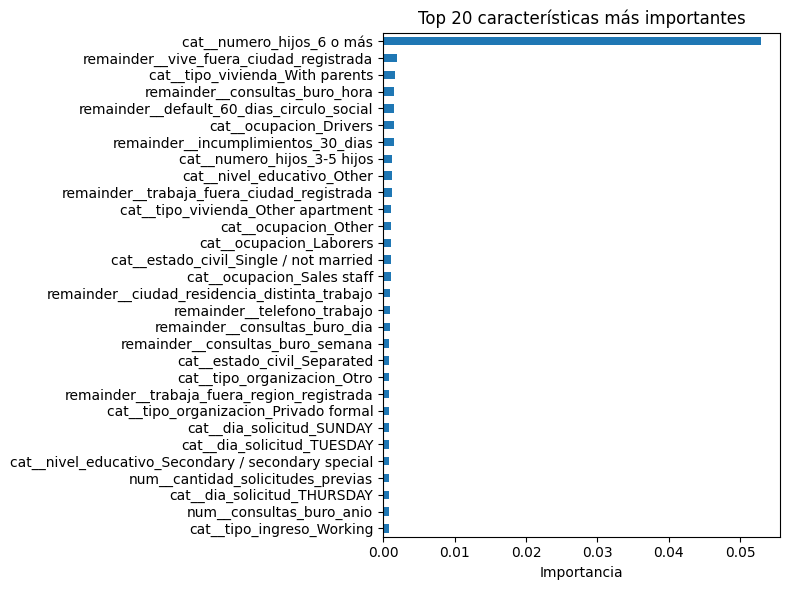

In [17]:
# Extraemos clasificador y nombres de features
clf     = best_pipe.named_steps['classifier']
prep    = best_pipe.named_steps['preprocessor']
feat_names = prep.get_feature_names_out()

# Calculamos "importancia" según el tipo de NB
if isinstance(clf, GaussianNB):
    # |μ1 - μ0| / σ0
    imp = np.abs(clf.theta_[1] - clf.theta_[0]) / np.sqrt(clf.var_[0])
elif isinstance(clf, MultinomialNB):
    # diferencia en log‑probabilidades
    imp = np.abs(clf.feature_log_prob_[1] - clf.feature_log_prob_[0])
elif isinstance(clf, (BernoulliNB, ComplementNB, CategoricalNB)):
    # mismo criterio de log‑prob
    imp = np.abs(clf.feature_log_prob_[1] - clf.feature_log_prob_[0])
else:
    raise ValueError(f"Tipo de clasificador no soportado: {type(clf)}")

# Serie ordenada y top‑30
imp_series = pd.Series(imp, index=feat_names).sort_values(ascending=False)
top20      = imp_series.head(30)

# Gráfico
plt.figure(figsize=(8,6))
top20.plot.barh()
plt.gca().invert_yaxis()
plt.title("Top 20 características más importantes")
plt.xlabel("Importancia")
plt.tight_layout()
plt.show()


# 16. Guardado del Pipeline Final

In [18]:
joblib.dump(best_pipe, "pipeline_nb_combined.pkl")
print("Pipeline guardado en 'pipeline_nb_combined.pkl'")

Pipeline guardado en 'pipeline_nb_combined.pkl'
